# Explore the female ICD chapter vs male ICD chapter correlation

In [1]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

from ast import literal_eval
from common import *
from mimic_common import *
from multiprocess import Pool
import os
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import time


/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = os.path.join(os.path.expanduser("~"), f"EHR-OT/outputs/mimic")
print(f"Will save outputs to {output_dir}")

Will save outputs to /home/wanxinli/EHR-OT/outputs/mimic


In [3]:
""" 
Read in the original dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})


In [4]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return target_reps, source_reps

In [5]:

""" 
Run experiments
"""

num_iteration = 100
male_count = 120
female_count = 100
combined_coupling = np.zeros(shape=[female_count, male_count])    
num_chapter = 20
chapter_corr_matrix_combined = np.zeros(shape=[num_chapter, num_chapter])
n_components = 50

for i in range(num_iteration):
    print("iteration:", i)

    """
    Run the experiment
    """
    
    selected_df = select_df_cts(admid_diagnosis_df, male_count=male_count, female_count=female_count)
    selected_df = selected_df.drop(columns=['adm_type', 'diagnosis', 'label'])
    selected_df_male = selected_df[selected_df['gender']=='M']
    selected_df_female = selected_df[selected_df['gender']=='F']
    selected_df_male.to_csv(os.path.join(output_dir, "selected_df_male.csv"), header=True, index=True)
    selected_df_female.to_csv(os.path.join(output_dir, "selected_df_female.csv"), header=True, index=True)

    source_features, source_labels, target_features, target_labels = gen_features_duration(selected_df)
    target_reps, source_reps = custom_train_reps(target_features, source_features, n_components)

    ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
    ot_sinkhorn.fit(Xs=target_reps, Xt=source_reps)
    trans_target_reps = ot_sinkhorn.transform(Xs=target_reps)

    """
    Compute coupling
    """
    selected_df_female = selected_df_female.reset_index(drop=True)
    selected_df_male = selected_df_male.reset_index(drop=True)
    thres = 0 # only taking the couplings that exceed thres
    coupling_thres = np.zeros(shape=ot_sinkhorn.coupling_.shape)
    for i in range(ot_sinkhorn.coupling_.shape[0]): # for each column
        for j in range(ot_sinkhorn.coupling_.shape[1]):
            if ot_sinkhorn.coupling_[i][j] >= thres:
                coupling_thres[i][j] = ot_sinkhorn.coupling_[i][j]


    """ 
    Compute chapter correlation matrix
    """
    chapter_corr_matrix = np.zeros(shape=[num_chapter, num_chapter])
    for target_index in range(coupling_thres.shape[0]):
        for source_index in range(coupling_thres.shape[1]):
            if coupling_thres[target_index][source_index] != 0:
                target_features = selected_df_female.iloc[target_index]['ICD codes']
                target_chapters = decide_all_ICD_chapters(target_features)
                source_features = selected_df_male.iloc[source_index]['ICD codes']
                source_chapters = decide_all_ICD_chapters(source_features)
                for target_chapter in target_chapters:
                    for source_chapter in source_chapters:
                        chapter_corr_matrix[target_chapter][source_chapter] += coupling_thres[target_index][source_index]
    
    """ 
    Compute chapter correlation matrix combined
    """
    chapter_corr_matrix_combined = np.add(chapter_corr_matrix_combined, chapter_corr_matrix)

""" 
Normalize chapter correlation matrix
"""
corr_sum = np.sum(chapter_corr_matrix_combined)
for i in range(chapter_corr_matrix_combined.shape[0]):
    for j in range(chapter_corr_matrix_combined.shape[1]):
        chapter_corr_matrix_combined[i][j] /= corr_sum

""" 
Prepare data for plotting the heatmap
"""
chapter_corr_vec = []
for i in range(chapter_corr_matrix_combined.shape[0]):
    for j in range(chapter_corr_matrix_combined.shape[1]):
        if chapter_corr_matrix_combined[i][j] != 0:
            chapter_corr_vec.append([i, j, chapter_corr_matrix_combined[i][j]])


chapter_corr_df = pd.DataFrame(chapter_corr_vec, columns=['target_chapter', 'source_chapter', 'density'])


chapter_corr_df.to_csv(os.path.join(output_dir, "exp4_chapter.csv"), index=False)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

/tmp/ipykernel_2669094/3475831552.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(chapter_corr_df.pivot('target_chapter', 'source_chapter', 'density'), cmap="Blues", yticklabels=yticklabels)


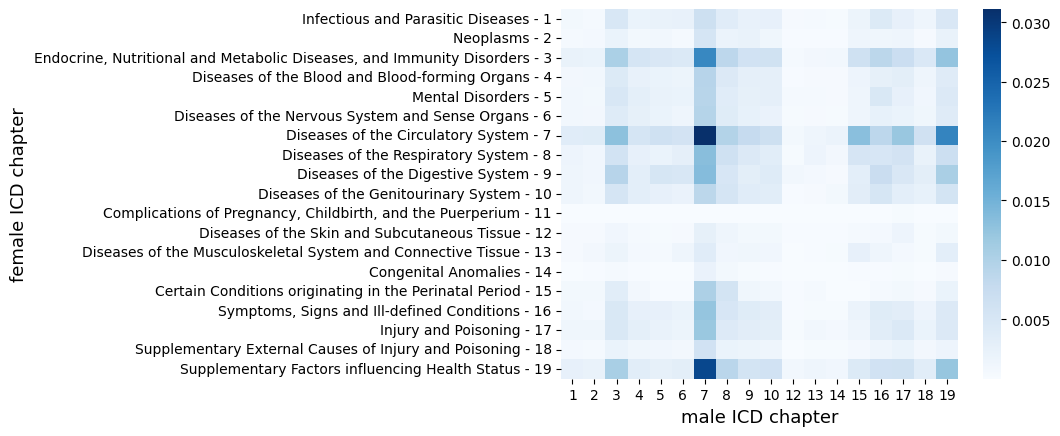

In [10]:
chapter_corr_df = pd.read_csv(os.path.join(output_dir, "exp4_chapter.csv"), index_col=None)
title_size = 13
yticklabels = ["Infectious and Parasitic Diseases - 1", 
               "Neoplasms - 2", 
               "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders - 3", \
                "Diseases of the Blood and Blood-forming Organs - 4", 
                "Mental Disorders - 5", 
                "Diseases of the Nervous System and Sense Organs - 6", \
                "Diseases of the Circulatory System - 7", 
                "Diseases of the Respiratory System - 8", 
                "Diseases of the Digestive System - 9", \
                "Diseases of the Genitourinary System - 10", 
                "Complications of Pregnancy, Childbirth, and the Puerperium - 11", 
                "Diseases of the Skin and Subcutaneous Tissue - 12",\
                "Diseases of the Musculoskeletal System and Connective Tissue - 13", 
                "Congenital Anomalies - 14", 
                "Certain Conditions originating in the Perinatal Period - 15", \
                "Symptoms, Signs and Ill-defined Conditions - 16", 
                "Injury and Poisoning - 17",
                "Supplementary External Causes of Injury and Poisoning - 18",
                "Supplementary Factors influencing Health Status - 19"]

ax = sns.heatmap(chapter_corr_df.pivot('target_chapter', 'source_chapter', 'density'), cmap="Blues", yticklabels=yticklabels)
plt.xlabel("male ICD chapter", fontsize=title_size)
plt.ylabel("female ICD chapter", fontsize=title_size)
save_path = os.path.join(output_dir, "exp4_chapter_correlation.pdf")
plt.savefig(save_path, bbox_inches='tight')
plt.show()
